### Read sample data

The test last for 30 minutes, there are a total of 2 - 4 channels to be measured. Measurement is done every 20 seconds on all channels. Currently we have 2 channel, but in the future we will have 4 channel.

At each measuremnt, a total of 120 data point is collected. Measurement on 1 channel normally takes less than 1-2 seconds.

This sample data is the data collected on 1 channel during the test. It is a list of 90 measurements. For each measurement, it consits of a start/end potential for this measurement and 120 current data.

For example, the first measurement: 

```
[
    [
      -0.407,
      0.193
    ],
    [
      7.952,
      9.462,
      9.058,
      .
      .
      .
    ],
    ...
```

The starting potential is -.407V, ending potential is 0.193V, 120 data point is collected. Current values are 7.952... etc.

In [18]:
# load the data.
# you can change './sample.json' to your own JSON data file.
# the sample json data is using a non-standard affix because of my gitignore.
import json
data = json.load(open('./sample.json.txt'))

### Data format

In [10]:
# the totoal time points of the data:
print(f'There are a total of {len(data)} measurements.')

print(f'The start and ending potential of the first measurement is {data[0][0][0]}V and {data[0][0][1]}V.')

print(f'The first measurement result: {data[0][1]}')
print(f"The first measurement result's length is {len(data[0][1])}")

There are a total of 90 measurements.
The start and ending potential of the first measurement is -0.452V and 0.148V.
The first measurement result: [6.773, 7.777, 7.427, 7.141, 6.869, 6.549, 6.306, 6.055, 5.839, 5.649, 5.519, 5.359, 5.19, 5.082, 4.991, 4.879, 4.818, 4.728, 4.641, 4.606, 4.637, 4.663, 4.723, 4.836, 4.888, 5.039, 5.242, 5.446, 5.688, 6.03, 6.458, 6.873, 7.375, 7.98, 8.551, 9.152, 9.875, 10.502, 11.181, 11.955, 12.742, 13.504, 14.187, 14.931, 15.519, 16.034, 16.497, 16.791, 16.856, 16.981, 16.903, 16.921, 16.696, 16.397, 15.887, 15.433, 14.961, 14.252, 13.59, 12.972, 12.189, 11.575, 10.796, 10.082, 9.191, 8.447, 7.708, 6.856, 6.138, 5.545, 4.909, 4.442, 4.031, 3.599, 3.331, 3.101, 2.911, 2.742, 2.617, 2.539, 2.431, 2.375, 2.331, 2.288, 2.284, 2.275, 2.245, 2.228, 2.219, 2.215, 2.171, 2.219, 2.228, 2.232, 2.215, 2.249, 2.245, 2.253, 2.284, 2.292, 2.292, 2.349, 2.357, 2.379, 2.431, 2.465, 2.461, 2.504, 2.526, 2.548, 2.582, 2.656, 2.686, 2.729, 2.764, 2.811, 2.829, 2.863, 2.9

In [11]:
### show one of the data and the format to be returned from M355
index = -1
print('One of the returned repsonse from M355 is:')
print(json.dumps({"r":data[index][1]},separators=(',',':')) + '*')

One of the returned repsonse from M355 is:
{"r":[11.242,12.738,12.076,11.497,10.965,10.424,9.948,9.602,9.17,8.828,8.547,8.123,7.781,7.548,7.28,6.99,6.773,6.622,6.484,6.25,6.203,5.908,5.77,5.645,5.558,5.415,5.312,5.255,5.212,5.151,5.126,5.026,5.039,5.113,5.138,5.208,5.342,5.454,5.692,5.952,6.237,6.432,6.821,7.267,7.66,8.145,8.711,9.196,9.866,10.489,11.069,11.527,12.072,12.626,13.106,13.564,13.992,14.248,14.672,14.836,14.832,14.702,14.468,14.226,13.75,13.361,12.894,12.215,11.726,11.125,10.398,9.693,9.079,8.517,7.825,7.31,6.769,6.224,5.835,5.467,5.087,4.749,4.485,4.23,4.027,3.901,3.737,3.603,3.521,3.439,3.339,3.253,3.192,3.136,3.08,3.045,2.993,2.933,2.946,2.907,2.881,2.837,2.82,2.768,2.742,2.734,2.699,2.695,2.695,2.677,2.673,2.647,2.63,2.595,2.625,2.613,2.587,2.595,2.608,2.595]}*


This is how the raw data looks:


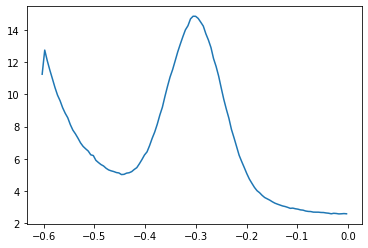

In [12]:
### plot the raw data
from util import plotFit
import numpy as np
index = -1
potentials = np.linspace(*data[index][0],len(data[index][1]))
currents = data[index][1]
print('This is how the raw data looks:')
plotFit(potentials,currents)

### perform data analysis to find the measurement value at each measurement

The operation is done in real time, whenever a measurement is finished, the raw data is processed to generate the fitting result. The raw data can be discarded, only store the fitting result.



In [13]:
# the peak fitting algorithm is in the util module. 
# you can look in to details. 
# certain algorithms from python packages are used. We need to migrate those algorithms as well.

from util import myfitpeak,plotFit
import numpy as np

fits = []
for v,a in data:
    fits.append(myfitpeak(np.linspace(*v,len(a)),a))


In [14]:
print(json.dumps(fits[-1],indent=2))

{
  "fx": [
    -0.4517394957983193,
    -0.10888235294117649
  ],
  "fy": [
    5.124098337219376,
    2.9336986844382498
  ],
  "pc": 10.463934434787408,
  "pv": -0.30047899159663866,
  "err": 0.05306931050581011
}


### Fitting result
- `pc` is the peak high in the figure below.(green verticle line). This is the value we use for downstream calling.
- `fx, fy` are the cordinates of the peak base. (left and right intersection point of the orange line)
- `pv` is the peak center.
- `err` is a estimation of how close the peak is to a normal distribution. 

This is demonstrating how the raw measurement and one of fitting result looks like:


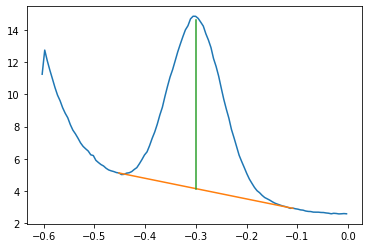

In [15]:
# This is demonstrating how the raw measurement and one of fitting result looks like 
print('This is demonstrating how the raw measurement and one of fitting result looks like:')
index = -1
potentials = np.linspace(*data[index][0],len(data[index][1]))
currents = data[index][1]
plotFit(potentials , currents, fits[index] )

### Perform the result calling from the time course result

The `pc` value at each measurement from the previous step is used to predict whether the channel is positive or negative.

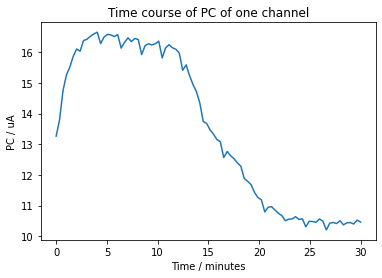

In [16]:
# Here is how the time course curve normally looks like
# plotting is just for show here.
import matplotlib.pyplot as plt
plt.plot( np.linspace(0,30,len(fits)) ,  [i['pc'] for i in fits])
plt.ylabel('PC / uA')
plt.xlabel('Time / minutes')
plt.title('Time course of PC of one channel')
plt.show()

In [17]:

from util import hCtTPredictT,convert_list_to_X

# t is the time points, the measurement is taken over 30 minutes, and a total of len(fits) measurements.
t = np.linspace(0,30,len(fits))
# c is all the `pc` in fitting result
c = [i['pc'] for i in fits]
data = [[t,c]]

# the convert_list_to_X is just to transform the data to the shape that works with the scipy pipeline.
X = convert_list_to_X(data)

# hCtPredictT is the pipeline that transforms and fits the data to give calling result.
result = hCtTPredictT.transform(X)

call, Ct, prominance, signal_drop = result[0]

print(f"The result is {'Positive' if call else 'Negative'}.")
print(f"The reaction Ct is {Ct:.2f} minutes.")
print(f"The prominance is {prominance:.4f}.")
print(f"The signal drop is {signal_drop:.4f}.")

The result is Positive.
The reaction Ct is 12.80 minutes.
The prominance is 1.3104.
The signal drop is 0.1987.


### You can look into the `hCtTPredictT` pipeline to see what calculations are done.

The calculations utilizes some python packages, these functions need to be migrated.